In [1]:
!pip install uproot3
!pip install uproot_methods
!pip install mplhep
!pip install awkward

     |████████████████████████████████| 122kB 6.5MB/s 
     |████████████████████████████████| 92kB 5.1MB/s 
     |████████████████████████████████| 92kB 4.9MB/s 
     |████████████████████████████████| 5.4MB 5.3MB/s 


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import uproot3 as ROOT
import uproot_methods as upm
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import font_manager
import mplhep as hep


/usr/local/lib/python3.6/dist-packages/uproot3/__init__.py:138: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  FutureWarning
/usr/local/lib/python3.6/dist-packages/awkward0/__init__.py:23: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  FutureWarning


In [4]:
## 리딩 투젯 마스크
def jet_ht_cut(data,nb):
  globals()['jet_mask{}'.format(nb)] = np.zeros(data.shape)
  for i in range(0,len(data)):
    if data.counts[i] >= 2:
     globals()['jet_mask{}'.format(nb)][i] = data[i,0] + data[i,1]

In [5]:
## 리딩 투렙 마스크
def lepton_global(data1,data2,phi1,phi2,nb):
  globals()['lep_mask{}'.format(nb)] = np.zeros(data1.shape)
  globals()['sub_mask{}'.format(nb)] = np.zeros(data1.shape)
  globals()['lep_phi{}'.format(nb)] = np.zeros(data1.shape)
  globals()['sub_phi{}'.format(nb)] = np.zeros(data1.shape)
  globals()['z_mask{}'.format(nb)] = np.zeros(data1.shape)
  for i in range(0,len(data1)):
    if (data1.counts[i] + data2.counts[i] >= 2):
      if (data1.counts[i] == 0):
        globals()['lep_mask{}'.format(nb)][i] = data2[i,0]
        globals()['sub_mask{}'.format(nb)][i] = data2[i,1]
        globals()['lep_phi{}'.format(nb)][i] = phi2[i,0]
        globals()['sub_phi{}'.format(nb)][i] = phi2[i,1]
      elif (data2.counts[i] == 0):
        globals()['lep_mask{}'.format(nb)][i] = data1[i,0]
        globals()['sub_mask{}'.format(nb)][i] = data1[i,1]
        globals()['lep_phi{}'.format(nb)][i] = phi1[i,0]
        globals()['sub_phi{}'.format(nb)][i] = phi1[i,1]
      else:
        if (data1[i,0] > data2[i,0]):
          globals()['lep_mask{}'.format(nb)][i] = data1[i,0]
          globals()['sub_mask{}'.format(nb)][i] = data2[i,0]
          globals()['lep_phi{}'.format(nb)][i] = phi1[i,0]
          globals()['sub_phi{}'.format(nb)][i] = phi2[i,0]
        else:
          globals()['lep_mask{}'.format(nb)][i] = data2[i,0]
          globals()['sub_mask{}'.format(nb)][i] = data1[i,0]
          globals()['lep_phi{}'.format(nb)][i] = phi2[i,0]
          globals()['sub_phi{}'.format(nb)][i] = phi1[i,0]

In [6]:
def pt2pxpy(pt1,phi1,pt2,phi2,met,phi3,nb):
  globals()['lep{}_px'.format(nb)] = pt1 * np.cos(phi1)
  globals()['lep{}_py'.format(nb)] = pt1 * np.sin(phi1)
  globals()['sub{}_px'.format(nb)] = pt2 * np.cos(phi2)
  globals()['sub{}_py'.format(nb)] = pt2 * np.sin(phi2)
  globals()['MET{}_px'.format(nb)] = met * np.cos(phi3)
  globals()['MET{}_py'.format(nb)] = met * np.sin(phi3)

In [7]:
def recal_momenta(visApx, visApy, visBpx, visBpy, invpx, invpy):
  global invVector
  global visAVector
  global visBVector
  invVector = np.array([np.zeros(invpx.shape),invpx,invpy])
  visAVector = np.array([np.zeros(visApx.shape),visApx,visApy])
  visBVector = np.array([np.zeros(visBpx.shape),visBpx,visBpy])

In [8]:
def nsols_massless(Dsq):
  delta = Dsq / (2*Easq)
  d2 = d21 * delta + d20
  e2 = e21 * delta + e20
  f2 = f22 * delta * delta + f21 * delta + f20
  a = np.ones(delta.shape)
  b = np.ones(delta.shape)

  for i in range (len(pax)):
    if (pax[i] > 0):
      a[i] = Ea[i] / Dsq[i]
      b[i] = -Dsq[i] / (4 * Ea[i])
    else:
      a[i] = -Ea[i] / Dsq[i]
      b[i] = Dsq[i] / (4 * Ea[i])
  A4 = a*a*a2
  A3 = 2*a*b2/Ea
  A2 = (2*a*a2*b+c2+2*a*d2)/(Easq)
  A1 = (2*b*b2+2*e2)/(Easq*Ea)
  A0 = (a2*b*b+2*b*d2+f2)/(Easq*Easq)

  A0sq = A0 * A0
  A1sq = A1 * A1
  A2sq = A2 * A2
  A3sq = A3 * A3
  A4sq = A4 * A4

  B3 = 4 * A4
  B2 = 3* A3
  B1 = 2 * A2
  B0 = A1
  C2 = -(A2/2 - 3*A3sq/(16*A4))
  C1 = -(3*A1/4. -A2*A3/(8*A4))
  C0 = -A0 + A1*A3/(16*A4)
  D1 = -B1 - (B3*C1*C1/C2 - B3*C0 -B2*C1)/C2
  D0 = -B0 -B3 * C0 * C1 / (C2*C2) + B2*C0/C2
  E0 = -C0 - C2 * D0 * D0 / (D1 * D1) + C1 * D0 / D1

  t1 = A4
  t2 = A4
  t3 = C2
  t4 = D1
  t5 = E0
  nsol = signchange_n(t1,t2,t3,t4,t5) - signchange_p(t1,t2,t3,t4,t5)
  return nsol

In [9]:
def signchange_n(t1,t2,t3,t4,t5):
  nsc = np.zeros(t1.shape)
  for i in range(len(t1)):
    if (t1[i] * t2[i] > 0):
      nsc[i] += 1
    if (t2[i] * t3[i] > 0):
      nsc[i] += 1
    if (t3[i] * t4[i] > 0):
      nsc[i] += 1
    if (t4[i] * t5[i] > 0):
      nsc[i] += 1
    return nsc


def signchange_p(t1,t2,t3,t4,t5):
  nsc = np.zeros(t1.shape)
  for i in range(len(t1)):
    if (t1[i] * t2[i] < 0):
      nsc[i] += 1
    if (t2[i] * t3[i] < 0):
      nsc[i] += 1
    if (t3[i] * t4[i] < 0):
      nsc[i] += 1
    if (t4[i] * t5[i] < 0):
      nsc[i] += 1
    return nsc

In [10]:
dat1 = ROOT.open("/content/drive/MyDrive/Event_Sample/pow_delph_nlo.root")["Delphes"]

In [11]:
MET1_arr, Elec1_PT_arr, Muon1_PT_arr, Jet1_PT_arr = dat1.arrays(['MissingET.MET', 'Electron.PT', 'Muon.PT', 'Jet.PT'],outputtype=tuple)
Lepton_Mass_arr = np.zeros(Elec1_PT_arr.shape)
Elec1_Eta_arr, Elec1_Phi_arr, Muon1_Eta_arr, Muon1_Phi_arr = dat1.arrays(['Electron.Eta', 'Electron.Phi', 'Muon.Eta', 'Muon.Phi'],outputtype=tuple)
MET1_Eta_arr, MET1_Phi_arr = dat1.arrays(['MissingET.Eta', 'MissingET.Phi'],outputtype=tuple)

lepton_global(Elec1_PT_arr,Muon1_PT_arr,Elec1_Phi_arr,Muon1_Phi_arr,1)

In [12]:
pt2pxpy(lep_mask1,lep_phi1,sub_mask1,sub_phi1,MET1_arr,MET1_Phi_arr,1)
recal_momenta(lep1_px,lep1_py,sub1_px,sub1_py,MET1_px,MET1_py)

In [13]:
pax = visAVector[1]
pay = visAVector[2]
pbx = visBVector[1]
pby = visBVector[2]
pmissx = invVector[1]
pmissy = invVector[2]

In [14]:
## 데이터 전처리, 0인 놈들은 다 걸러냅니다.
test_pax = []
test_pay = []
test_pbx = []
test_pby = []
test_pmissx = []
test_pmissy = []

In [15]:
for i in range(len(pax)):
  if pax[i] == 0:
    continue
  else:
    test_pax.append(pax[i])
    test_pay.append(pay[i])
    test_pbx.append(pax[i])
    test_pby.append(pbx[i])
    test_pmissx.append(pmissx[i])
    test_pmissy.append(pmissy[i])

In [16]:
  pax = np.array(test_pax)
  pay = np.array(test_pay)
  pbx = np.array(test_pbx)
  pby = np.array(test_pby)
  pmissx = np.array(test_pmissx).flatten()
  pmissy = np.array(test_pmissy).flatten()

In [17]:
print(test_pax,test_pay,test_pbx,test_pby,test_pmissx,test_pmissy)

[41.85431242811891, -44.934541292872545, 43.319359935193205, -55.09687306660313, 73.62311878965936, -57.40318064020845, 68.35381436604423, -61.979460253665316, -53.20802341860193, -88.8734934781436, -197.76628795139774, -30.65166419081054, -35.18344061778576, 89.77826273419724, -64.89785687218811, 56.64936985249608, 113.71560639531603, -0.5660966832803714, -98.71787403094307, 27.96324023642839, 74.61607728587148, 58.19920231603084, -33.943972314749786, 21.68223080185031, 27.40712271957464, 26.62810020517288, -143.62405255764185, -77.61248516113355, 56.7187696493934, 14.334361053527887, 67.3461435742163, 67.13671428378318, 191.59866033314418, -50.176782297355686, -9.655972723354994, 25.99236927146038, 42.97976208556195, 49.448071269233346, -2.7421761402183527, -33.95821724740511, -11.871625340324597, 28.974107964372287, -39.41159714627981, 6.921885715812667, -42.64270579972815, 69.26980715149848, -36.50813397227527, 42.98055861833484, 40.02649235936442, 72.34865110314567, -81.8028747748

In [18]:
masq = np.zeros(pax.shape)
Easq = pax * pax + pay * pay
Ea = np.sqrt(Easq)
mbsq = np.zeros(pax.shape)
Ebsq = pbx * pbx + pby * pby
Eb = np.sqrt(Ebsq)
print(Ea)
print(Eb)

[42.032547   57.68159485 57.44906998 ... 98.1830368  44.80603027
 94.9133606 ]
[55.38656058 45.55608257 51.59017273 ... 75.67892904 49.72113599
 84.55413235]


In [19]:
pmissxsq = pmissx * pmissx
pmissysq = pmissy * pmissy
scale = np.ones(pax.shape)
metsq = (pmissxsq + pmissysq) ** 0.5
print(pmissx)
print(pmissy)
print(scale)

[-12.557408    9.965473   24.436743  ...  -7.2176943  60.202053
  26.208673 ]
[ -9.992616  58.96439   -9.517323 ...  48.073586  17.921638 140.14117 ]
[1. 1. 1. ... 1. 1. 1.]


In [20]:
for i in range(len(Ea)):
  if (Ea[i] > Eb[i]):
    scale[i] = Ea[i] / 100
  elif (Ea[i] < Eb[i]):
    scale[i] = Eb[i] / 100
  if Ea[i] == 0:
    scale[i] = 1
  if ((metsq / 100)[i] > scale[i]):
    scale[i] = metsq[i] / 100

scalesq = scale * scale
print(scale)

[0.55386561 0.59800583 0.5744907  ... 0.98183037 0.62812992 1.42570831]


In [21]:
pax /= scale
pay /= scale
pbx /= scale
pby /= scale
Ea /= scale
Eb /= scale
Easq /= scalesq
Ebsq /= scalesq

pmissx /= scale
pmissy /= scale
pmissxsq /= scalesq
pmissysq /= scalesq
precision = np.ones(pax.shape) * 0.001

In [22]:
print(pax,pay)
print(pbx,pby)
print(pmissx)

[ 75.56763227 -75.14064098  75.4048063  ...  69.84550846  41.92388034
  58.52650738] [  6.98133601  60.47937814 -65.68192436 ... -71.56538932 -57.71224365
 -31.72668402]
[ 75.56763227 -75.14064098  75.4048063  ...  69.84550846  41.92388034
  58.52650738] [ 65.49452613  12.54097678  48.76924255 ... -32.60128972  67.14375166
   9.58848353]
[-22.672302  16.664509  42.536358 ...  -7.351264  95.843315  18.382914]


In [23]:
theta = np.zeros(pax.shape)
for i in range(len(theta)):
  if pax[i] != 0:
    theta[i] = np.arctan(pay[i]/pax[i])

print(theta)

[ 0.09212377 -0.67771092 -0.71659273 ... -0.79755986 -0.94255173
 -0.49675065]


In [24]:
## 로테이션
s = np.sin(theta)
c = np.cos(theta)
pxtemp = pax * c + pay * s
pax = pxtemp
pay = np.zeros(pax.shape)
pxtemp = pbx * c + pby * s
pytemp = -s * pmissx + c * pmissy
pbx = pxtemp
pby = pytemp
pxtemp = pmissx * c + pmissy * s
pytemp = -s * pmissx + c * pmissy
pmissx = pxtemp
pmissy = pytemp

print(pax)
print(pay)
print(pbx)
print(pby)
print(pmissx)
print(pmissy)

[ 75.88943338 -96.45657628 100.         ... 100.          71.33242468
  66.5727763 ]
[0. 0. 0. ... 0. 0. 0.]
[ 81.27226763 -66.39864954  24.82627113 ...  72.11519043 -29.68362316
  46.88314732]
[-15.87938142  87.26055166  15.44673119 ...  28.93765634  94.31186402
  95.1761426 ]
[-24.23587207 -48.84257556  42.95568038 ... -40.17525399  33.24565306
 -30.68390527]
[-15.87938142  87.26055166  15.44673119 ...  28.93765634  94.31186402
  95.1761426 ]


In [25]:
a2 = 1 - pbx * pbx / (Ebsq)
b2 = -pbx * pby/(Ebsq)
c2 = 1 - pby * pby / (Ebsq)
print(a2,b2,c2)

[0.33948185 0.24030969 0.92357155 ... 0.1246606  0.85937883 0.37507887] [ 0.12905533  0.99837867 -0.04755324 ... -0.35124737  0.44678658
 -1.26863459] [ 0.97478452 -0.31206092  0.97041271 ...  0.859055   -0.41954621
 -1.57541895]


In [26]:
d21 = (Easq * pbx) / Ebsq
d20 = - pmissx + (pbx*(pbx * pmissx + pby *pmissy)) / Ebsq
e21 = (Easq * pby) / Ebsq
e20 = -pmissy + (pby * (pbx * pmissx + pby * pmissy)) / Ebsq
f22 = -(Easq * Easq / Ebsq)
f21 = -2 * Easq * (pbx * pmissx + pby * pmissy) / Ebsq
f20 = 0.0 + pmissxsq + pmissysq - (pbx * pmissx + pby * pmissy) * (pbx * pmissx + pby * pmissy) / Ebsq
print(f21,f20)

[  1978.34434191 -34812.96452986  -3236.55373763 ...   6934.10276007
 -12843.42078821 -19202.88928684] [   544.5345889  -10313.11565371   1872.60210902 ...   1737.27532102
     19.86059034  -6508.01195184]


In [27]:
Deltasq0 = 0.0
Deltasq_low = Deltasq0 + precision
nsols_low = nsols_massless(Deltasq_low)
print(nsols_low)

[0. 0. 0. ... 0. 0. 0.]


In [28]:
mt2_b = np.ones(nsols_low.shape)

for i in range(len(mt2_b)):
  if (nsols_low[i] > 1):
    mt2_b[i] = 0

In [29]:
Deltasq_high1 = 2 * Eb * (pmissx*pmissx + pmissy*pmissy)**0.5 -2 * pbx * pmissx -2 *pby * pmissy
Deltasq_high2 = np.zeros(Deltasq_high1.shape)
Deltasq_high = Deltasq_high1

In [30]:
for i in range(len(Deltasq_high)):
  if (Deltasq_high1[i] < Deltasq_high2[i]):
    Deltasq_high[i] = Deltasq_high2[i]

nsols_high = nsols_massless(Deltasq_high)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [31]:
print(nsols_low)
print(nsols_high)
print(Deltasq_high)

[0. 0. 0. ... 0. 0. 0.]
[2. 0. 0. ... 0. 0. 0.]
[ 9230.03563411     0.          5588.56578416 ... 11752.43145801
    15.72984701     0.        ]


In [32]:
minmass = np.zeros(nsols_high.shape)
maxmass = minmass
print(type(maxmass))
print(type(Deltasq_high))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [33]:
for i in range(len(nsols_high)):
  if (nsols_high[i] == nsols_low[i]):
    foundhigh=0
    #minmass = np.zeros(nsols_high.shape) # mn
    maxmass[i] = Deltasq_high[i]**0.5

    for mass in range(0,int(maxmass[i]*10)):
      Deltasq_high[i] = mass*mass/100 - 0 #mnsq
      if (nsols_high[i]>0):
        foundhigh=1
        Deltasq_low[i] = (mass-0.1)*(mass-0.1) - 0 #mnsq
    if foundhigh==0:
      mt2_b[i] = np.sqrt(Deltasq_low[i]+0) #mnsq
    
    if (nsols_high[i] == nsols_low[i]):
      mt2_b[i] =  np.sqrt(Deltasq_low[i])


In [34]:
print(mt2_b)

[1.         0.03162278 0.03162278 ... 0.03162278 0.03162278 0.03162278]


In [35]:
minmass = Deltasq_low ** 0.5
maxmass = Deltasq_high ** 0.5
print(minmass)
print(maxmass)

[0.03162278 0.03162278 0.03162278 ... 0.03162278 0.03162278 0.03162278]
[ 96.07307445   0.          74.6        ... 108.3          3.8
   0.        ]


In [38]:
## 본게임 코드
midmass = np.zeros(maxmass.shape)
Delta_mid = np.zeros(maxmass.shape)
nsols_mid = np.zeros(maxmass.shape)
cnt = 0
for i in range(len(maxmass)):
  while (maxmass[i] -minmass[i] > precision[i]):
    midmass[i] = (minmass[i]+maxmass[i])/2.
    Delta_mid[i] = midmass[i] * midmass[i] - 0 #mnsq
    nsols_mid = nsols_massless(Delta_mid)
    if (nsols_mid[i] != nsols_low[i]):
      maxmass[i] = midmass[i]
    if (nsols_mid[i] == nsols_low[i]):
      minmass[i] = midmass[i]
  mt2_b[i] = minmass[i]
  cnt+=1
  if (cnt % 50 == 0 ):
    print("running",cnt)

running 50


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


running 100
running 150
running 200
running 250
running 300
running 350
running 400
running 450
running 500
running 550
running 600
running 650
running 700
running 750
running 800
running 850
running 900
running 950
running 1000
running 1050
running 1100
running 1150
running 1200
running 1250
running 1300
running 1350
running 1400
running 1450
running 1500
running 1550
running 1600
running 1650
running 1700
running 1750
running 1800
running 1850
running 1900
running 1950
running 2000
running 2050
running 2100
running 2150
running 2200
running 2250
running 2300
running 2350
running 2400
running 2450
running 2500
running 2550
running 2600
running 2650
running 2700
running 2750
running 2800
running 2850
running 2900
running 2950
running 3000
running 3050
running 3100
running 3150
running 3200
running 3250
running 3300
running 3350
running 3400
running 3450
running 3500
running 3550
running 3600
running 3650
running 3700
running 3750
running 3800
running 3850


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


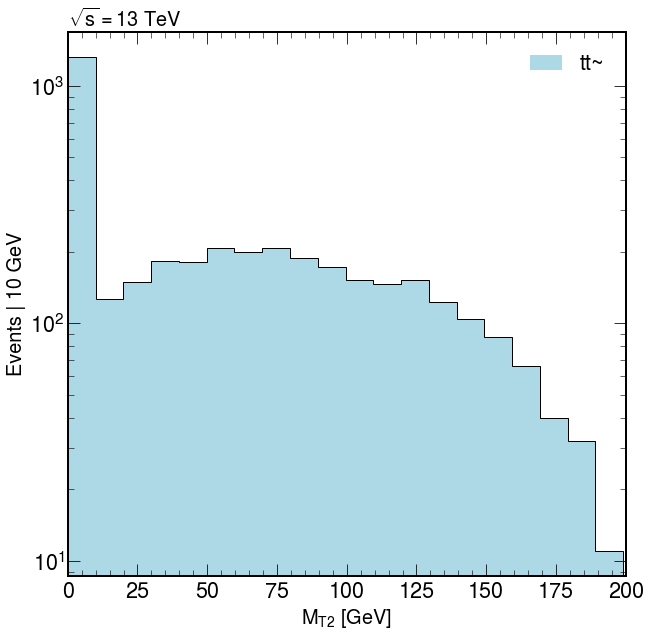

In [39]:
## 그림그리기
plt.style.use(hep.style.CMS)
plt.hist(mt2_b, bins=20,color='lightblue',label='tt~')
plt.hist(mt2_b,bins=20,color = 'black',histtype='step')
plt.xlim(0,200)
plt.xlabel("$M$$_{T2}$ [GeV]",fontsize=20)
plt.ylabel("Events | 10 GeV",fontsize=20)
plt.legend()
plt.yscale('log')
plt.title("$\sqrt{s} = 13$ TeV", loc='left',fontsize=20)
plt.show()

In [40]:
### 과제1 : 질량이 있는 "b jet"을 고려한 코드 생성 (현재는 massless daughter만 고려)
### 과제2 : 모듈화와 경량화(현재 너무 느리다. 특히 for if while 3중구조를 회피할 수 있는 방안 착안)
### 과제3 : 암흑물질 신호사건에 mn을 고려하는지? 고려한다면 컷이 달라지는데?
### 과제4 : 이 결과를 컷으로 적용하기 위한 마스크 착안